# Pair Trading Strategy

## Import Libraries

In [1]:
import wrds # type: ignore
conn = wrds.Connection()

import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import scipy.stats as si # type: ignore
from scipy import optimize # type: ignore
import statsmodels.api as sm # type: ignore

Loading library list...
Done


## Dates

In [37]:
def get_dates(date, duration, duration_type):
    if not isinstance(date, str):
        raise ValueError('Date must be a string in the format YYYY-MM-DD.')
    end_date = pd.to_datetime(date)
    if duration_type == 'years':
        start_date = end_date - pd.DateOffset(years=duration)
    elif duration_type == 'months':
        start_date = end_date - pd.DateOffset(months=duration)
    elif duration_type == 'days':
        start_date = end_date - pd.DateOffset(days=duration)
    else:
        raise ValueError('Invalid duration type. Please choose from years, months, or days.')
    
    print(f'Start date: {start_date.strftime("%m/%d/%Y")}')
    print(f'End date: {end_date.strftime("%m/%d/%Y")}')
    return start_date, end_date

start_date, end_date = get_dates('2021-01-01', 5, 'years')

Start date: 01/01/2016
End date: 01/01/2021


# Getting the SP500 companies

In [2]:
# https://wrds-www.wharton.upenn.edu/pages/wrds-research/applications/python-replications/historical-sp-500-index-constituents/

# Extract S&P 500 data from CRSP
sp500 = conn.raw_sql("""
    SELECT a.*, b.date, b.ret
    FROM crsp.msp500list AS a
    JOIN crsp.msf AS b ON a.permno = b.permno
    WHERE b.date >= a.start 
    AND b.date <= a.ending 
    AND b.date >= '01/01/2000'
    ORDER BY date;
    """, date_cols=['start', 'ending', 'date'])

# Add company names and additional descriptive data from CRSP's msenames
mse = conn.raw_sql("""
    SELECT comnam, ncusip, namedt, nameendt, permno, shrcd, exchcd, hsiccd, ticker
    FROM crsp.msenames;
    """, date_cols=['namedt', 'nameendt'])

# Replace missing 'nameendt' with today's date
mse['nameendt'] = mse['nameendt'].fillna(pd.to_datetime('today'))

# Merge S&P 500 data with descriptive variables (mse data)
sp500_full = pd.merge(sp500, mse, how='left', on='permno')

# Filter rows to ensure date range alignment between SP500 data and company names
sp500_full = sp500_full[(sp500_full['date'] >= sp500_full['namedt']) & 
                        (sp500_full['date'] <= sp500_full['nameendt'])]

# Extract Compustat linkage data (CCM)
ccm = conn.raw_sql("""
    SELECT gvkey, liid AS iid, lpermno AS permno, linktype, linkprim, linkdt, linkenddt
    FROM crsp.ccmxpf_linktable
    WHERE SUBSTR(linktype,1,1) = 'L' 
    AND (linkprim = 'C' OR linkprim = 'P');
    """, date_cols=['linkdt', 'linkenddt'])

# Replace missing 'linkenddt' with today's date
ccm['linkenddt'] = ccm['linkenddt'].fillna(pd.to_datetime('today'))

# Merge CCM data with S&P500 data using PERMNO
sp500ccm = pd.merge(sp500_full, ccm, how='left', on='permno')

# Filter data based on link date range
sp500ccm = sp500ccm[(sp500ccm['date'] >= sp500ccm['linkdt']) & 
                    (sp500ccm['date'] <= sp500ccm['linkenddt'])]

# Drop unnecessary columns
sp500ccm = sp500ccm.drop(columns=['namedt', 'nameendt', 'linktype', 'linkprim', 'linkdt'])

# Rearrange columns for final output
sp500ccm = sp500ccm[['date', 'permno', 'comnam', 'ncusip', 'shrcd', 'exchcd', 'hsiccd', 'ticker', 
                     'gvkey', 'iid', 'start', 'ending', 'ret', 'linkenddt']]

sp500ccm['comnam'] = sp500ccm['comnam'].str.replace(' ', '_', regex=False)

# Count the number of companies (permno) by date
cnt = sp500ccm.groupby(['date'])['permno'].count().reset_index().rename(columns={'permno': 'npermno'})

# Show the processed data (e.g., sample)
sp500ccm

,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret,linkenddt
0,2000-01-31,77178,QUALCOMM_INC,74752510,11,3,3663,QCOM,024800,01,1999-07-22,2023-12-29,-0.278921,2024-10-10 12:39:50.873340
1,2000-01-31,48485,JEFFERSON_PILOT_CORP,47507010,11,1,6311,JP,006241,01,1976-07-01,2006-03-31,-0.139194,2006-03-31 00:00:00.000000
4,2000-01-31,19502,WALGREEN_CO,93142210,11,1,5912,WAG,011264,01,1979-10-11,2023-12-29,-0.044872,2024-10-10 12:39:50.873340
6,2000-01-31,28847,U_S_AIRWAYS_GROUP_INC,91190510,11,1,4512,U,010946,01,1986-12-18,2002-05-14,-0.311891,2002-08-09 00:00:00.000000
7,2000-01-31,56573,ILLINOIS_TOOL_WORKS_INC,45230810,11,1,3569,ITW,005878,01,1986-02-13,2023-12-29,-0.134135,2024-10-10 12:39:50.873340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182502,2023-12-29,22111,JOHNSON_&_JOHNSON,47816010,11,1,3841,JNJ,006266,01,1973-05-31,2023-12-29,0.013449,2024-10-10 12:39:50.873340
182503,2023-12-29,44206,EVERSOURCE_ENERGY,30040W10,11,1,4924,ES,007970,01,2009-03-17,2023-12-29,0.050244,2024-10-10 12:39:50.873340
182505,2023-12-29,23473,CINCINNATI_FINANCIAL_CORP,17206210,11,3,6330,CINF,014824,01,1997-12-18,2023-12-29,0.013815,2024-10-10 12:39:50.873340
182506,2023-12-29,77274,GILEAD_SCIENCES_INC,37555810,11,3,2830,GILD,024856,01,2004-07-01,2023-12-29,0.067363,2024-10-10 12:39:50.873340


In [35]:
# https://wrds-www.wharton.upenn.edu/pages/wrds-research/applications/python-replications/historical-sp-500-index-constituents/

def get_data(start_date, end_date):
    # Extract S&P 500 data from CRSP
    sp500_query = f"""
    SELECT a.*, b.date, b.ret
    FROM crsp.msp500list AS a
    JOIN crsp.msf AS b ON a.permno = b.permno
    WHERE b.date >= a.start 
    AND b.date <= a.ending 
    AND b.date >= '01/01/2000'
    ORDER BY date;
    """
    sp500 = conn.raw_sql(sp500_query, date_cols=['start', 'ending', 'date'])
    ## REVIEW line "AND b.date <= '{end_date.strftime('%m/%d/%Y')}'"
    
    # Add company names and additional descriptive data from CRSP's msenames
    mse_query = """
    SELECT comnam, ncusip, namedt, nameendt, permno, shrcd, exchcd, hsiccd, ticker
    FROM crsp.msenames;
    """
    mse = conn.raw_sql(mse_query, date_cols=['namedt', 'nameendt'])
    
    # Replace missing 'nameendt' with today's date
    mse['nameendt'] = mse['nameendt'].fillna(pd.to_datetime('today'))
    
    # Merge S&P 500 data with descriptive variables (mse data)
    sp500_full = pd.merge(sp500, mse, how='left', on='permno')

    # Filter rows to ensure date range alignment between SP500 data and company names
    sp500_full = sp500_full[(sp500_full['date'] >= sp500_full['namedt']) & (sp500_full['date'] <= sp500_full['nameendt'])]

    # Extract Compustat linkage data (CCM)
    ccm_query = """
    SELECT gvkey, liid AS iid, lpermno AS permno, linktype, linkprim, linkdt, linkenddt
    FROM crsp.ccmxpf_linktable
    WHERE SUBSTR(linktype,1,1) = 'L' 
    AND (linkprim = 'C' OR linkprim = 'P');
    """
    ccm = conn.raw_sql(ccm_query, date_cols=['linkdt', 'linkenddt'])

    # Replace missing 'linkenddt' with today's date
    ccm['linkenddt'] = ccm['linkenddt'].fillna(pd.to_datetime('today'))
    ## REVIEW line "ccm['linkenddt'] = ccm['linkenddt'].fillna(pd.to_datetime('today'))"

    # Merge CCM data with S&P500 data using PERMNO
    sp500ccm = pd.merge(sp500_full, ccm, how='left', on='permno')

    # Filter data based on link date range
    sp500ccm = sp500ccm[(sp500ccm['date'] >= sp500ccm['linkdt']) & 
                        (sp500ccm['date'] <= sp500ccm['linkenddt'])]

    # Drop unnecessary columns
    sp500ccm = sp500ccm.drop(columns=['namedt', 'nameendt', 'linktype', 'linkprim', 'linkdt'])

    # Rearrange columns for final output
    sp500ccm = sp500ccm[['date', 'permno', 'comnam', 'ncusip', 'shrcd', 'exchcd', 'hsiccd', 'ticker', 
                        'gvkey', 'iid', 'start', 'ending', 'ret', 'linkenddt']]

    sp500ccm['comnam'] = sp500ccm['comnam'].str.replace(' ', '_', regex=False)

    # Count the number of companies (permno) by date
    cnt = sp500ccm.groupby(['date'])['permno'].count().reset_index().rename(columns={'permno': 'npermno'})
    
    # Return the processed data (e.g., sample)
    print('Data extraction completed.')
    return sp500ccm


get_data(start_date, end_date)

Data extraction completed.


,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending,ret,linkenddt
0,2000-01-31,77178,QUALCOMM_INC,74752510,11,3,3663,QCOM,024800,01,1999-07-22,2023-12-29,-0.278921,2024-10-10 13:11:33.345428
1,2000-01-31,48485,JEFFERSON_PILOT_CORP,47507010,11,1,6311,JP,006241,01,1976-07-01,2006-03-31,-0.139194,2006-03-31 00:00:00.000000
4,2000-01-31,19502,WALGREEN_CO,93142210,11,1,5912,WAG,011264,01,1979-10-11,2023-12-29,-0.044872,2024-10-10 13:11:33.345428
6,2000-01-31,28847,U_S_AIRWAYS_GROUP_INC,91190510,11,1,4512,U,010946,01,1986-12-18,2002-05-14,-0.311891,2002-08-09 00:00:00.000000
7,2000-01-31,56573,ILLINOIS_TOOL_WORKS_INC,45230810,11,1,3569,ITW,005878,01,1986-02-13,2023-12-29,-0.134135,2024-10-10 13:11:33.345428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182502,2023-12-29,22111,JOHNSON_&_JOHNSON,47816010,11,1,3841,JNJ,006266,01,1973-05-31,2023-12-29,0.013449,2024-10-10 13:11:33.345428
182503,2023-12-29,44206,EVERSOURCE_ENERGY,30040W10,11,1,4924,ES,007970,01,2009-03-17,2023-12-29,0.050244,2024-10-10 13:11:33.345428
182505,2023-12-29,23473,CINCINNATI_FINANCIAL_CORP,17206210,11,3,6330,CINF,014824,01,1997-12-18,2023-12-29,0.013815,2024-10-10 13:11:33.345428
182506,2023-12-29,77274,GILEAD_SCIENCES_INC,37555810,11,3,2830,GILD,024856,01,2004-07-01,2023-12-29,0.067363,2024-10-10 13:11:33.345428


In [3]:
cnt

,date,npermno
0,2000-01-31,500
1,2000-02-29,500
2,2000-03-31,500
3,2000-04-28,500
4,2000-05-31,500
...,...,...
283,2023-08-31,500
284,2023-09-29,500
285,2023-10-31,500
286,2023-11-30,500


### Get the pernmos of the actual SP500

In [4]:
# Get the list of permno for the S&P 500 companies
sp500ccm_current = sp500ccm[sp500ccm['date'] == sp500ccm['date'].max()]
permno_SP500 = sp500ccm_current[['comnam', 'permno']]
permno_SP500

,comnam,permno
181900,C_B_O_E_GLOBAL_MARKETS_INC,93429
181901,ABBVIE_INC,13721
181902,CITIZENS_FINANCIAL_GROUP_INC,14889
181904,MERCK_&_CO_INC_NEW,22752
181905,BIO_TECHNE_CORP,75694
...,...,...
182502,JOHNSON_&_JOHNSON,22111
182503,EVERSOURCE_ENERGY,44206
182505,CINCINNATI_FINANCIAL_CORP,23473
182506,GILEAD_SCIENCES_INC,77274


### Get the stock prices for SP500

In [5]:
start_date = '2010-01-01'
end_date =   '2020-12-31'

def calculate_return_stock(permno_SP500, start_date=start_date, end_date=end_date):

    # Get the list of permnos for the S&P 500 companies
    permno_list = permno_SP500['permno'].tolist()

    # Adjust the start_date to begin 10 days earlier
    start_date1 = pd.to_datetime(start_date) - pd.DateOffset(days=10)

    # SQL query to get stock prices between the adjusted start_date and end_date
    query = f"""
    SELECT date, permno, prc
        FROM crsp.dsf
        WHERE permno IN ({', '.join([str(p) for p in permno_list])})
        AND date >= '{start_date1}'
        AND date <= '{end_date}'
    """
   
    stock_prices = pd.DataFrame(conn.raw_sql(query))
    stock_prices['date'] = pd.to_datetime(stock_prices['date'])

    # Pivot the data to have permno as columns and date as the index
    return_pivoted = stock_prices.pivot(index='date', columns='permno', values='prc')

    # Mapper permnos aux noms d'entreprises
    permno_to_name = permno_SP500.set_index('permno')['comnam'].to_dict()
    
    # Renommer les colonnes de 'prc_permno' à 'prc_nomdelentreprise'
    return_pivoted.columns = [f"prc_{permno_to_name[int(col)]}" for col in return_pivoted.columns]

    # Create a full range of dates between the start and end dates
    full_dates = pd.date_range(start=start_date1, end=end_date, freq='D')

    # Reindex the DataFrame to include all dates in the range, and fill missing values with the previous day's price
    return_pivoted = return_pivoted.reindex(full_dates).ffill()

    # Return the DataFrame starting from the actual start_date, keeping date as index
    return return_pivoted[return_pivoted.index >= start_date]


stock_prices_SP500 = calculate_return_stock(permno_SP500)
stock_prices_SP500

,prc_ORACLE_CORP,prc_MICROSOFT_CORP,prc_T_ROWE_PRICE_GROUP_INC,prc_HONEYWELL_INTERNATIONAL_INC,prc_ARCHER_DANIELS_MIDLAND_CO,prc_FISERV_INC,prc_COCA_COLA_CO,prc_CADENCE_DESIGN_SYSTEMS_INC,prc_CONSOLIDATED_EDISON_INC,prc_FAIR_ISAAC_CORP,...,prc_VISA_INC,prc_AMERICAN_WATER_WORKS_CO_INC,prc_UNITEDHEALTH_GROUP_INC,prc_BROADCOM_INC,prc_VERISK_ANALYTICS_INC,prc_DOLLAR_GENERAL_CORP_NEW,prc_FORTINET_INC,prc_GENERAC_HOLDINGS_INC,prc_C_B_O_E_GLOBAL_MARKETS_INC,prc_TESLA_INC
2010-01-01,24.53,30.48000,53.25,39.20,31.31,48.48,57.00,5.99000,45.43,21.31000,...,87.46,22.41000,30.48000,18.29000,30.28,22.43000,17.57000,NaN,NaN,NaN
2010-01-02,24.53,30.48000,53.25,39.20,31.31,48.48,57.00,5.99000,45.43,21.31000,...,87.46,22.41000,30.48000,18.29000,30.28,22.43000,17.57000,NaN,NaN,NaN
2010-01-03,24.53,30.48000,53.25,39.20,31.31,48.48,57.00,5.99000,45.43,21.31000,...,87.46,22.41000,30.48000,18.29000,30.28,22.43000,17.57000,NaN,NaN,NaN
2010-01-04,24.85,30.95000,54.40,40.35,31.47,49.43,57.04,6.12000,45.38,21.65000,...,88.14,22.65000,31.53000,18.86000,29.85,23.08000,18.00000,NaN,NaN,NaN
2010-01-05,24.82,30.96000,55.01,40.43,31.64,49.64,56.35,6.06000,44.79,21.46000,...,87.13,22.88000,31.48000,19.00000,30.05,23.26000,18.39000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,64.96,222.75000,148.28,209.53,49.44,112.63,53.44,134.00000,70.44,518.45001,...,208.70,149.14000,340.79001,431.45999,201.23,211.28000,149.78999,233.20000,92.05,661.77002
2020-12-28,64.87,224.96001,148.06,209.94,49.70,112.67,54.16,134.75999,71.26,508.42001,...,212.63,149.64999,345.95001,431.88000,207.98,210.39000,149.28999,233.03999,93.30,663.69000
2020-12-29,64.46,224.14999,148.38,209.13,49.45,111.87,54.13,133.98000,70.76,507.51001,...,214.37,150.73000,347.35001,429.04001,205.67,211.34000,147.53000,221.37000,91.66,665.98999
2020-12-30,64.40,221.67999,149.58,210.95,49.91,112.88,54.44,135.25000,71.02,503.95001,...,218.36,150.63000,344.98999,434.82999,205.78,209.92999,148.02000,229.19000,92.62,694.78003


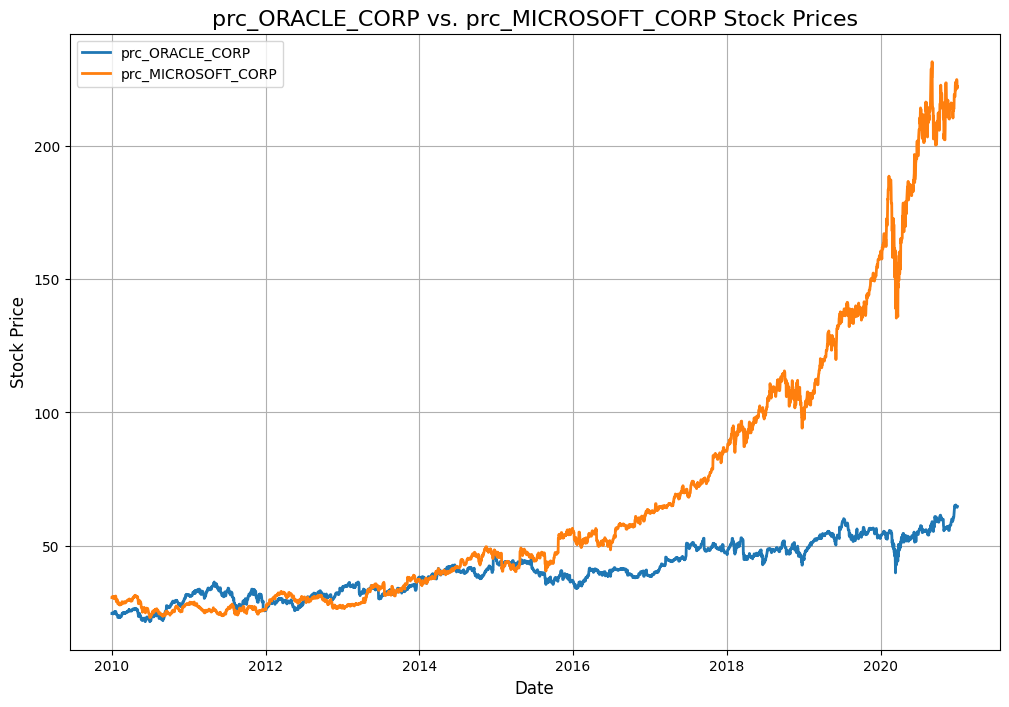

In [6]:
def plot_pair(stockA, stockB):

    plt.figure(figsize=(12, 8))
    plt.plot(stock_prices_SP500[stockA], label=stockA, linewidth=2)
    plt.plot(stock_prices_SP500[stockB], label=stockB, linewidth=2)
    plt.title(f'{stockA} vs. {stockB} Stock Prices', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)

    plt.show()

plot_pair(stock_prices_SP500.columns[0], stock_prices_SP500.columns[1])


# Correlation

In [7]:
# Calculate the daily returns
returns = stock_prices_SP500.pct_change()
returns.iloc[0] = 0
returns

,prc_ORACLE_CORP,prc_MICROSOFT_CORP,prc_T_ROWE_PRICE_GROUP_INC,prc_HONEYWELL_INTERNATIONAL_INC,prc_ARCHER_DANIELS_MIDLAND_CO,prc_FISERV_INC,prc_COCA_COLA_CO,prc_CADENCE_DESIGN_SYSTEMS_INC,prc_CONSOLIDATED_EDISON_INC,prc_FAIR_ISAAC_CORP,...,prc_VISA_INC,prc_AMERICAN_WATER_WORKS_CO_INC,prc_UNITEDHEALTH_GROUP_INC,prc_BROADCOM_INC,prc_VERISK_ANALYTICS_INC,prc_DOLLAR_GENERAL_CORP_NEW,prc_FORTINET_INC,prc_GENERAC_HOLDINGS_INC,prc_C_B_O_E_GLOBAL_MARKETS_INC,prc_TESLA_INC
2010-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
2010-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
2010-01-04,0.013045,0.015420,0.021596,0.029337,0.005110,0.019596,0.000702,0.021703,-0.001101,0.015955,...,0.007775,0.010710,0.034449,0.031165,-0.014201,0.028979,0.024474,NaN,NaN,NaN
2010-01-05,-0.001207,0.000323,0.011213,0.001983,0.005402,0.004248,-0.012097,-0.009804,-0.013001,-0.008776,...,-0.011459,0.010155,-0.001586,0.007423,0.006700,0.007799,0.021667,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-28,-0.001385,0.009921,-0.001484,0.001957,0.005259,0.000355,0.013473,0.005672,0.011641,-0.019346,...,0.018831,0.003420,0.015141,0.000973,0.033544,-0.004212,-0.003338,-0.000686,0.013580,0.002901
2020-12-29,-0.006320,-0.003601,0.002161,-0.003858,-0.005030,-0.007100,-0.000554,-0.005788,-0.007017,-0.001790,...,0.008183,0.007217,0.004047,-0.006576,-0.011107,0.004515,-0.011789,-0.050077,-0.017578,0.003465
2020-12-30,-0.000931,-0.011019,0.008087,0.008703,0.009302,0.009028,0.005727,0.009479,0.003674,-0.007015,...,0.018613,-0.000663,-0.006794,0.013495,0.000535,-0.006672,0.003321,0.035325,0.010473,0.043229


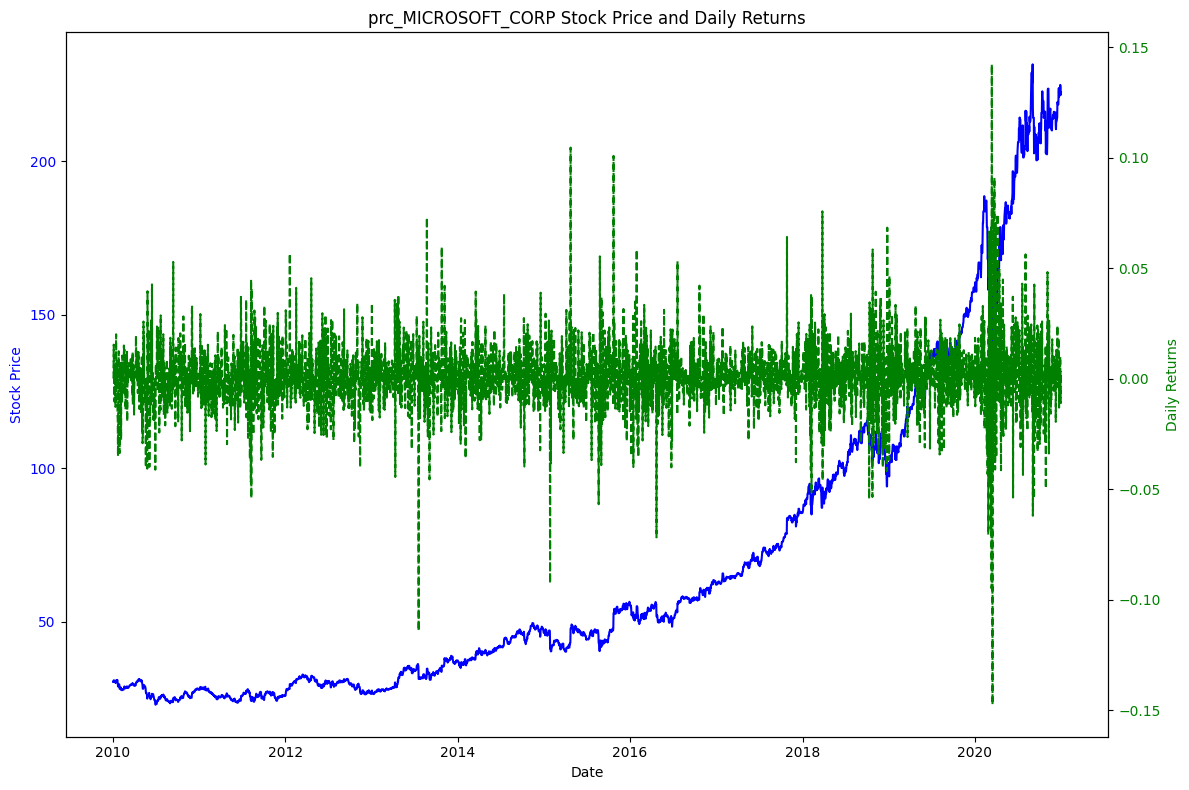

In [8]:
def plot_stock_and_returns(stock_prices, returns, stock_symbol):

    # Create a figure and two subplots
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plot stock prices on the first axis
    ax1.plot(stock_prices.index, stock_prices[stock_symbol], color='blue', label='Stock Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for returns
    ax2 = ax1.twinx()
    ax2.plot(returns.index, returns[stock_symbol], color='green', label='Daily Returns', linestyle='--')
    ax2.set_ylabel('Daily Returns', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Title and display the plot
    plt.title(f'{stock_symbol} Stock Price and Daily Returns')
    fig.tight_layout()
    plt.show()

# Example usage:
stock_symbol = 'prc_MICROSOFT_CORP'
plot_stock_and_returns(stock_prices_SP500, returns, stock_symbol)


## Compute the Correlation

In [9]:
def add_correlation(stock_returns):

    # Calculate the correlation matrix
    correlation_matrix = stock_returns.corr()

    # Unstack the correlation matrix to create a Series of stock pairs and their correlations
    pair_correlations = correlation_matrix.unstack().reset_index()

    # Rename the columns
    pair_correlations.columns = ['Stock 1', 'Stock 2', 'Correlation']

    # Remove duplicates and self-correlations (correlation of a stock with itself)
    pair_correlations = pair_correlations[pair_correlations['Stock 1'] != pair_correlations['Stock 2']]

    # Optional: Sort the pairs by their correlation coefficient
    pair_correlations = pair_correlations.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

    return pair_correlations

returns = stock_prices_SP500.pct_change()
returns.iloc[0] = 0
pairs = add_correlation(returns)
pairs

,Stock 1,Stock 2,Correlation
0,prc_CITIZENS_FINANCIAL_GROUP_INC,prc_KEYCORP_NEW,0.906147
1,prc_KEYCORP_NEW,prc_CITIZENS_FINANCIAL_GROUP_INC,0.906147
2,prc_REGIONS_FINANCIAL_CORP_NEW,prc_CITIZENS_FINANCIAL_GROUP_INC,0.900805
3,prc_CITIZENS_FINANCIAL_GROUP_INC,prc_REGIONS_FINANCIAL_CORP_NEW,0.900805
4,prc_REGENCY_CENTERS_CORP,prc_FEDERAL_REALTY_INVESTMENT_TR_NEW,0.894560
...,...,...,...
244525,prc_NISOURCE_INC,prc_AIRBNB_INC,-0.583087
244526,prc_ZEBRA_TECHNOLOGIES_CORP,prc_AIRBNB_INC,-0.614280
244527,prc_AIRBNB_INC,prc_ZEBRA_TECHNOLOGIES_CORP,-0.614280
244528,prc_AIRBNB_INC,prc_ATMOS_ENERGY_CORP,-0.733279


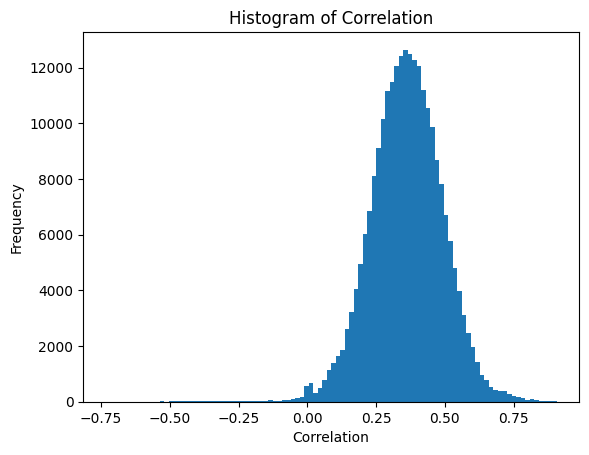

In [10]:
plt.hist(pairs['Correlation'], bins=100)
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation')
plt.show()

In [11]:
def select_high_correlation(correlation_pairs, threshold=0.8):

    # Filter pairs with correlation above the threshold
    high_correlation_pairs = correlation_pairs[correlation_pairs['Correlation'] > threshold]

    return high_correlation_pairs

pairs_correlated = select_high_correlation(pairs, threshold=0.8)
pairs_correlated

,Stock 1,Stock 2,Correlation
0,prc_CITIZENS_FINANCIAL_GROUP_INC,prc_KEYCORP_NEW,0.906147
1,prc_KEYCORP_NEW,prc_CITIZENS_FINANCIAL_GROUP_INC,0.906147
2,prc_REGIONS_FINANCIAL_CORP_NEW,prc_CITIZENS_FINANCIAL_GROUP_INC,0.900805
3,prc_CITIZENS_FINANCIAL_GROUP_INC,prc_REGIONS_FINANCIAL_CORP_NEW,0.900805
4,prc_REGENCY_CENTERS_CORP,prc_FEDERAL_REALTY_INVESTMENT_TR_NEW,0.894560
...,...,...,...
265,prc_JPMORGAN_CHASE_&_CO,prc_KEYCORP_NEW,0.800799
266,prc_WELLS_FARGO_&_CO_NEW,prc_FIFTH_THIRD_BANCORP,0.800421
267,prc_FIFTH_THIRD_BANCORP,prc_WELLS_FARGO_&_CO_NEW,0.800421
268,prc_PINNACLE_WEST_CAPITAL_CORP,prc_C_M_S_ENERGY_CORP,0.800253


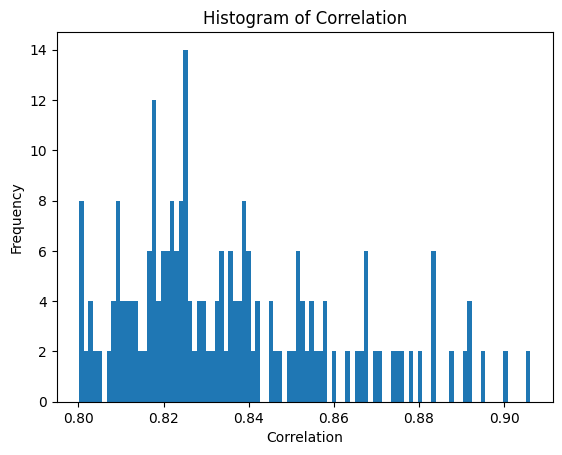

In [12]:
plt.hist(pairs_correlated['Correlation'], bins=100)
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation')
plt.show()

## Visualization

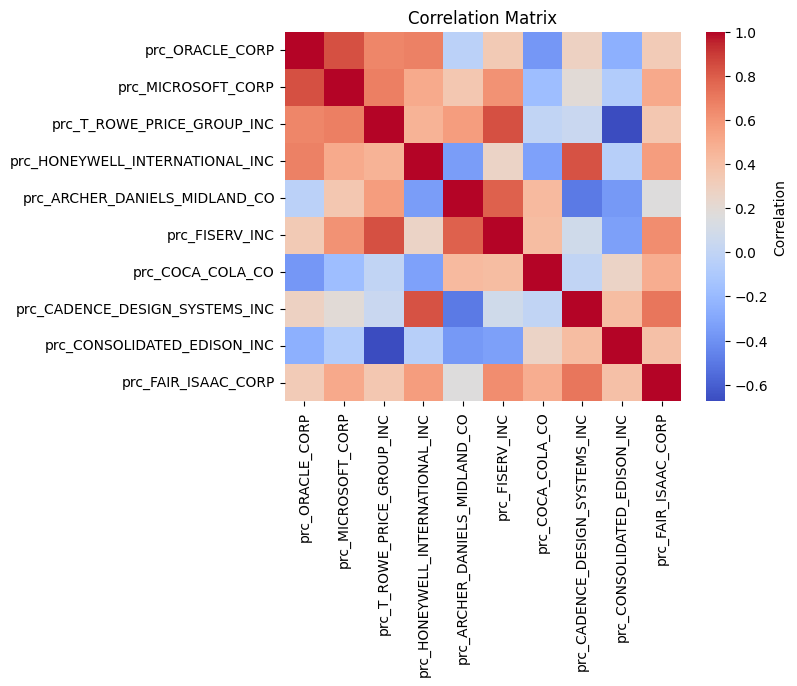

In [13]:
returns_square = returns.head(10).iloc[:, :10]
correlation_matrix = returns_square.corr()
correlation_matrix = correlation_matrix.head(10).iloc[:, :10]
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix')
plt.show()

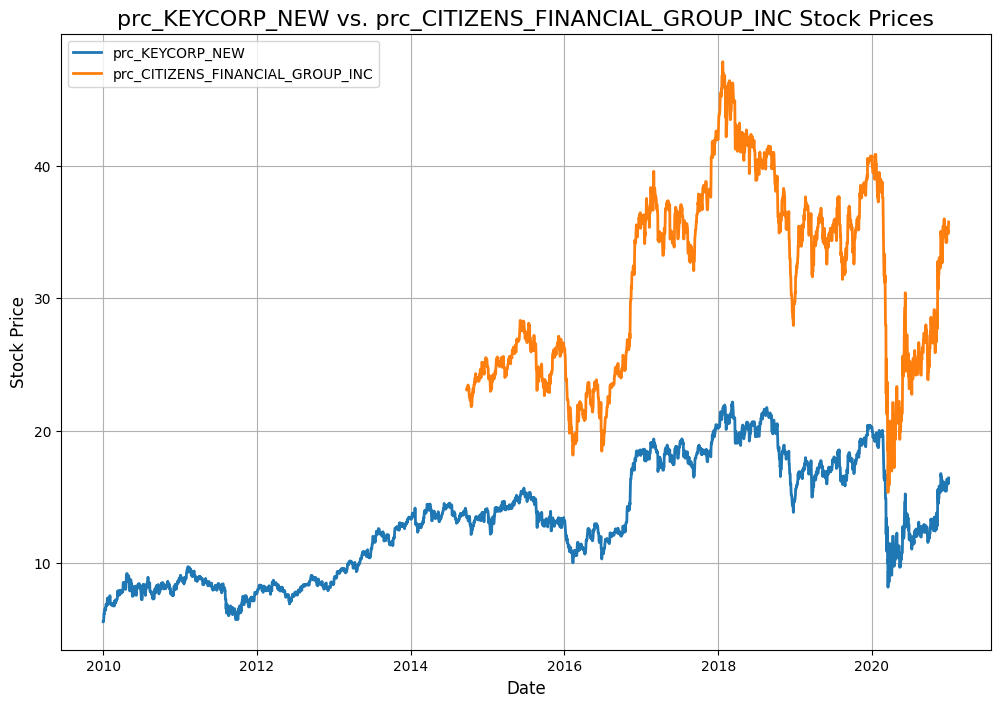

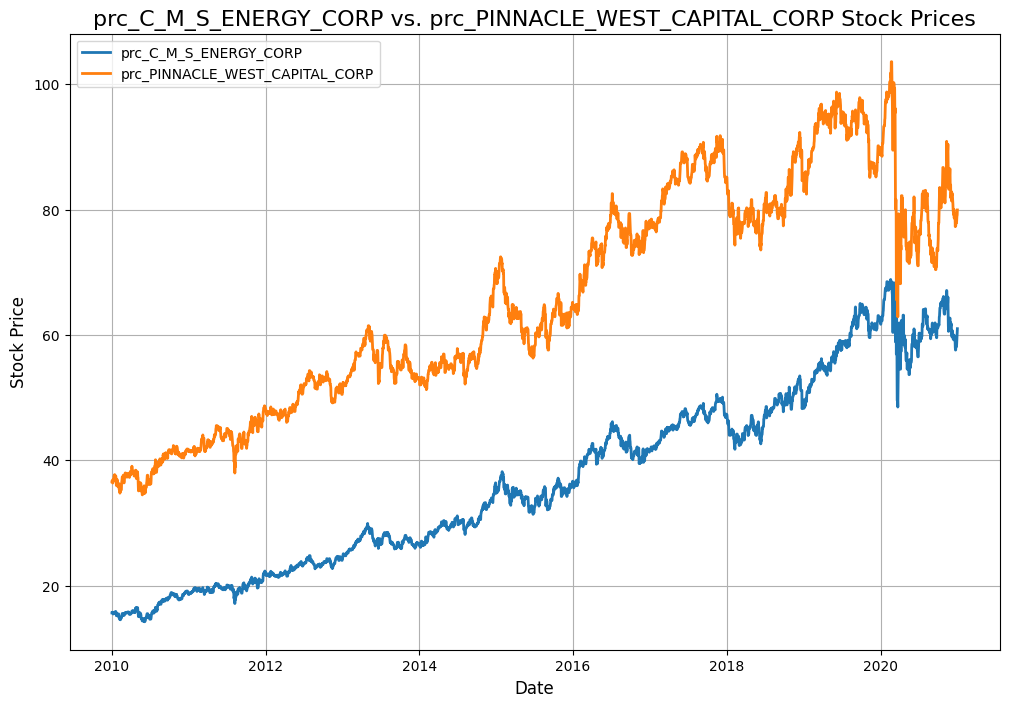

In [14]:
most_correlated_pair = pairs_correlated.iloc[1]
less_correlated_pair = pairs_correlated.iloc[len(pairs_correlated)-1]

stock1 = most_correlated_pair['Stock 1']
stock2 = most_correlated_pair['Stock 2']
stock3 = less_correlated_pair['Stock 1']
stock4 = less_correlated_pair['Stock 2']

plot_pair(stock1, stock2)
plot_pair(stock3, stock4)

# Co-Integration Test

### Defintion of Cointegration Test in Pair Trading

#### Definition of Cointegration

Cointegration is a statistical property of time series variables. Two time series are said to be **cointegrated** if they share a common long-term stochastic trend, even if they are individually non-stationary. In simpler terms, while the individual series may drift apart over time, their linear combination tends to revert to a stable mean.

Consider two time series, $X_{t}$ and $Y_{t}$. These series are individually non-stationary (their statistical properties change over time). However, if there exists a linear combination of the two series that results in a stationary process, then $X_{t}$ and $Y_{t}$ are **cointegrated**.

Mathematically, the relationship can be written as:

$Z_{t} = X_{t} - \beta Y_{t}$

Where:
- $Z_{t}$ is a stationary process (mean-reverting),
- $\beta$ is the **cointegration coefficient**, which reflects the long-term equilibrium relationship between $X_{t}$ and $Y_{t}$.

If $Z_{t}$ is stationary (i.e., it has a constant mean, variance, and no unit root), then the series $X_{t}$ and $Y_{t}$ are considered cointegrated.

#### Cointegration Test

The **Engle-Granger** cointegration test is a widely used method for testing whether two or more time series are cointegrated. It proceeds with the following steps:

1. **Estimate the Long-Run Relationship**:
   - Perform an Ordinary Least Squares (OLS) regression of $X_{t}$ on $Y_{t}$ to estimate the cointegration coefficient $\beta$.
   - This gives us the residuals $Z_{t}$, where:

  $Z_{t} = X_{t} - \hat{\beta} Y_{t}$

2. **Test for Stationarity**:
   - Apply a unit root test (such as the **Augmented Dickey-Fuller** test) on the residuals$Z_{t}$.
   - If the residuals are stationary, then $X_{t}$ and $Y_{t}$ are cointegrated, meaning their spread $Z_{t}$ is mean-reverting.

#### Null Hypothesis

The null hypothesis for the cointegration test is:

$H_0: \text{The series are not cointegrated.}$

If the p-value from the test is below a given threshold (e.g., 0.05), we reject the null hypothesis and conclude that the series are cointegrated.

#### Practical Use in Pair Trading

In pair trading, two stocks are selected based on their historical correlation. Once we confirm that the stocks are cointegrated, we can monitor the spread between them,$Z_{t}$. When the spread diverges significantly from its mean, a trader can take opposing positions in the two stocks (e.g., long one stock and short the other) expecting the spread to revert to the mean.

This strategy relies on the assumption that deviations from the long-term equilibrium will correct themselves, allowing the trader to profit from the convergence of the stock prices.


## Compute the Co-Integration Test

In [15]:
def add_test_cointegration_pairs(stock_data, high_correlation_return):
    
    cointegrated_pairs = []

    # Loop over each pair of stocks from the high correlation DataFrame
    for _, row in high_correlation_return.iterrows():
        stock_1 = row['Stock 1']
        stock_2 = row['Stock 2']
        correlation = row['Correlation']

        # Get the stock price data for the two stocks
        stock_1_prices = stock_data[stock_1]
        stock_2_prices = stock_data[stock_2]
        
        # Drop rows where either stock has missing (NaN) values
        combined_data = pd.concat([stock_1_prices, stock_2_prices], axis=1).dropna()
        
        # Re-extract clean series
        stock_1_clean = combined_data.iloc[:, 0]
        stock_2_clean = combined_data.iloc[:, 1]

        # Perform the cointegration test on the clean data
        score, p_value, _ = coint(stock_1_clean, stock_2_clean)

        cointegrated_pairs.append([stock_1, stock_2, correlation, p_value])

    # Create a DataFrame to store the results
    df_cointegration = pd.DataFrame(cointegrated_pairs, columns=['Stock 1', 'Stock 2', 'Correlation', 'P-Value'])
    
    # Sort by p-value in ascending order (lower p-values indicate stronger cointegration)
    df_cointegration.sort_values('P-Value', ascending=True, inplace=True)

    return df_cointegration


pairs_correlated = add_test_cointegration_pairs(stock_prices_SP500, pairs_correlated)
pairs_correlated

NameError: name 'coint' is not defined

## Visualization

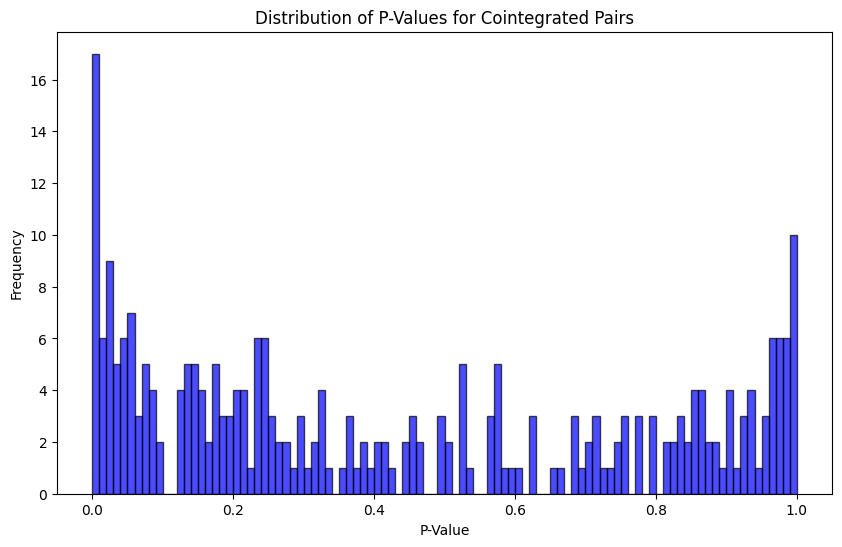

In [446]:
def visualize_p_values(return_correlated_cointegrated):

    # Plotting the histogram of p-values
    plt.figure(figsize=(10, 6))
    
    # Histogram to visualize the distribution of p-values
    plt.hist(return_correlated_cointegrated['P-Value'], bins=100, color='blue', edgecolor='black', alpha=0.7)
    
    plt.title('Distribution of P-Values for Cointegrated Pairs')
    plt.xlabel('P-Value')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.show()

# Appel de la fonction pour visualiser les p-values
visualize_p_values(pairs_correlated)

In [447]:
def select_high_cointegration(pairs_correlated, threshold=0.05):
    return pairs_correlated[pairs_correlated['P-Value'] <= threshold]

pairs_correlated_cointegrated = select_high_cointegration(pairs_correlated, threshold=0.05)
pairs_correlated_cointegrated

,Stock 1,Stock 2,Correlation,P-Value
6,prc_FIFTH_THIRD_BANCORP,prc_CITIZENS_FINANCIAL_GROUP_INC,0.892034,0.000080
7,prc_CITIZENS_FINANCIAL_GROUP_INC,prc_FIFTH_THIRD_BANCORP,0.892034,0.000104
59,prc_TRUIST_FINANCIAL_CORP,prc_FIFTH_THIRD_BANCORP,0.854322,0.001263
58,prc_FIFTH_THIRD_BANCORP,prc_TRUIST_FINANCIAL_CORP,0.854322,0.001294
166,prc_CAPITAL_ONE_FINANCIAL_CORP,prc_DISCOVER_FINANCIAL_SERVICES,0.823623,0.001972
248,prc_TEXAS_INSTRUMENTS_INC,prc_ANALOG_DEVICES_INC,0.808473,0.002431
240,prc_ZIONS_BANCORPORATION_N_A,prc_REGIONS_FINANCIAL_CORP_NEW,0.808918,0.002561
241,prc_REGIONS_FINANCIAL_CORP_NEW,prc_ZIONS_BANCORPORATION_N_A,0.808918,0.003514
60,prc_PRUDENTIAL_FINANCIAL_INC,prc_PRINCIPAL_FINANCIAL_GROUP_INC,0.853517,0.004652
249,prc_ANALOG_DEVICES_INC,prc_TEXAS_INSTRUMENTS_INC,0.808473,0.004765


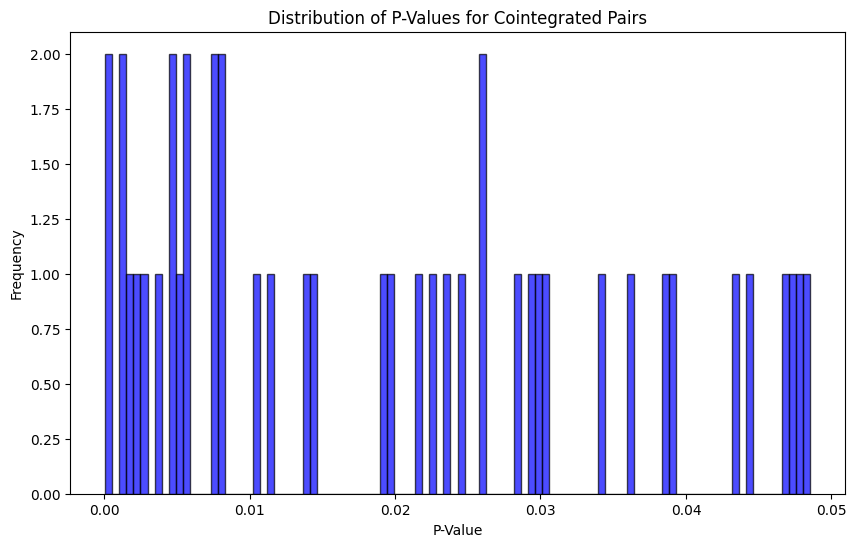

In [448]:
visualize_p_values(pairs_correlated_cointegrated)

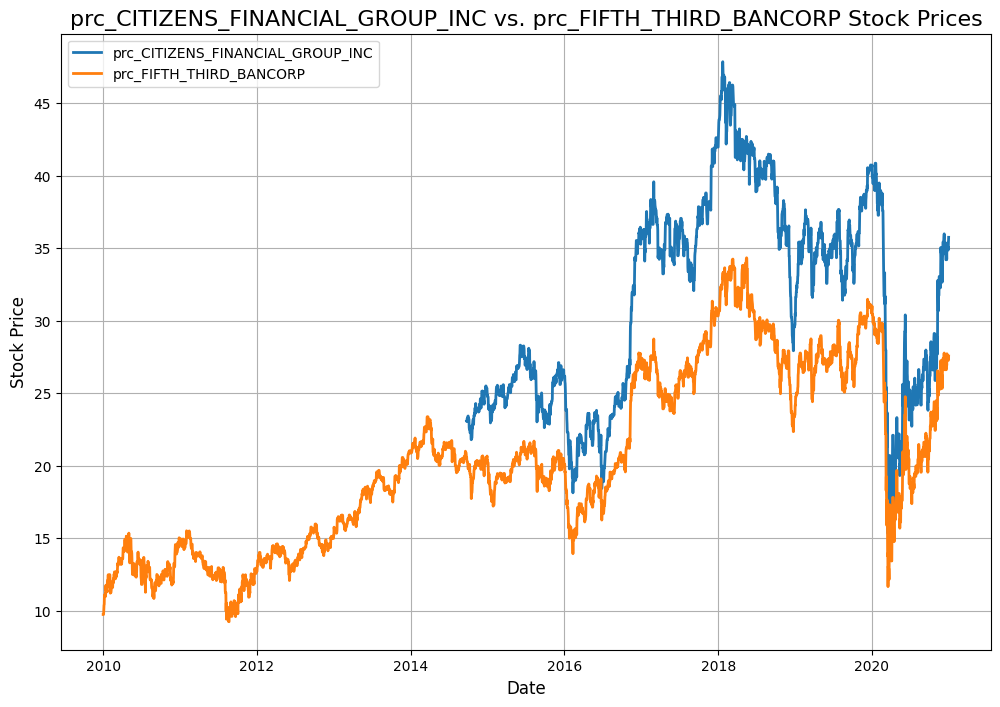

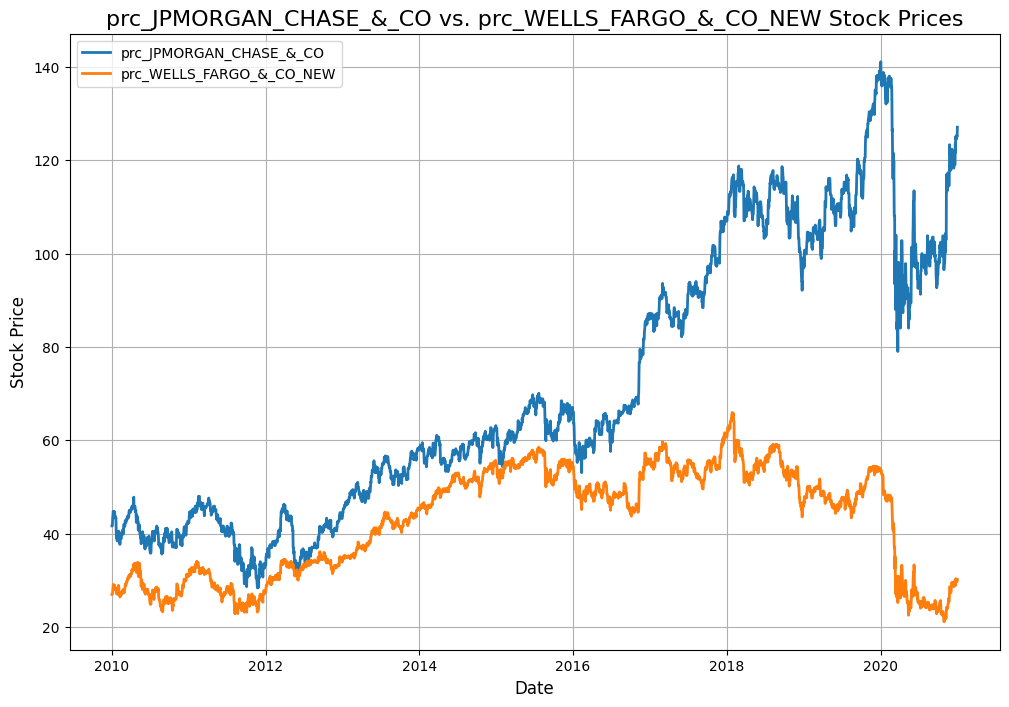

In [449]:
most_correlated_cointegrated_pair = pairs_correlated.iloc[1]
less_correlated_cointegrated_pair = pairs_correlated.iloc[len(pairs_correlated)-1]

stock1 = most_correlated_cointegrated_pair['Stock 1']
stock2 = most_correlated_cointegrated_pair['Stock 2']
stock3 = less_correlated_cointegrated_pair['Stock 1']
stock4 = less_correlated_cointegrated_pair['Stock 2']

plot_pair(stock1, stock2)
plot_pair(stock3, stock4)

# Spread

#### Definition of Spread in Pair Trading

In the context of **pair trading**, the **spread** represents the price difference between two correlated or cointegrated stocks. The spread is used to determine when to enter and exit positions in these stocks.

###### Spread Formula

For two stocks $X_{t}$ and $Y_{t}$, the spread can be calculated as follows:

$$
\text{Spread}_t = X_{t} - \beta Y_{t}
$$

Where:
- $X_{t}$ is the price of the first stock at time $t$,
- $Y_{t}$ is the price of the second stock at time $t$,
- $\beta$ is the **hedge ratio**, which is determined by running a linear regression of $X_{t}$ on $Y_{t}$.

###### Interpretation

The spread is often used as a measure of the **price relationship** between two assets. If the assets are cointegrated, the spread should oscillate around a stable mean. When the spread deviates significantly from this mean, it can indicate a trading opportunity:

- If the spread is **too high**, it suggests that stock $X_{t}$ is overvalued relative to $Y_{t}$, so one might **short** $X_{t}$ and **buy** $Y_{t}$.
- If the spread is **too low**, it suggests that $X_{t}$ is undervalued relative to $Y_{t}$, so one might **buy** $X_{t}$ and **short** $Y_{t}$.

The idea behind this strategy is that the spread will eventually revert to its historical mean, generating a profit when the positions are closed.


## Compute the Spread

In [450]:
def calculate_spread(stock_A, stock_B):

    # Combine the two stock series into a single DataFrame
    combined_data = pd.concat([stock_A, stock_B], axis=1)
    
    # Remove rows with NaN or infinite values
    combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_data = combined_data.dropna()

    # Extract clean stock prices
    stock_A_clean = combined_data.iloc[:, 0]
    stock_B_clean = combined_data.iloc[:, 1]

    # Perform linear regression of stock_A on stock_B to get the hedge ratio
    X = sm.add_constant(stock_B_clean)
    model = sm.OLS(stock_A_clean, X).fit()

    # Calculate the spread as the residual from the regression
    spread = stock_A_clean - model.predict(X)

    return spread

In [451]:
def calculate_spreads_for_pairs(stock_data, cointegrated_return):

    spreads_list = []  # Créer une liste pour stocker les DataFrames temporairement

    # Loop over each pair of cointegrated stocks
    for _, row in cointegrated_return.iterrows():
        stock_1 = row['Stock 1']
        stock_2 = row['Stock 2']
        
        # Get the price series for the two stocks
        stock_1_prices = stock_data[stock_1]
        stock_2_prices = stock_data[stock_2]
        
        # Calculate the spread using the calculate_spread function
        spread = calculate_spread(stock_1_prices, stock_2_prices)
        
        # Create a DataFrame for the spread
        spread_name = f'{stock_1}_vs_{stock_2}'
        temp_return = pd.DataFrame({spread_name: spread}, index=stock_data.index)
        
        # Add the spread DataFrame to the list
        spreads_list.append(temp_return)

    # Concatenate all the spread DataFrames into a single DataFrame
    spreads = pd.concat(spreads_list, axis=1)

    return spreads

spreads = calculate_spreads_for_pairs(stock_prices_SP500, pairs_correlated_cointegrated)
spreads

,prc_FIFTH_THIRD_BANCORP_vs_prc_CITIZENS_FINANCIAL_GROUP_INC,prc_CITIZENS_FINANCIAL_GROUP_INC_vs_prc_FIFTH_THIRD_BANCORP,prc_TRUIST_FINANCIAL_CORP_vs_prc_FIFTH_THIRD_BANCORP,prc_FIFTH_THIRD_BANCORP_vs_prc_TRUIST_FINANCIAL_CORP,prc_CAPITAL_ONE_FINANCIAL_CORP_vs_prc_DISCOVER_FINANCIAL_SERVICES,prc_TEXAS_INSTRUMENTS_INC_vs_prc_ANALOG_DEVICES_INC,prc_ZIONS_BANCORPORATION_N_A_vs_prc_REGIONS_FINANCIAL_CORP_NEW,prc_REGIONS_FINANCIAL_CORP_NEW_vs_prc_ZIONS_BANCORPORATION_N_A,prc_PRUDENTIAL_FINANCIAL_INC_vs_prc_PRINCIPAL_FINANCIAL_GROUP_INC,prc_ANALOG_DEVICES_INC_vs_prc_TEXAS_INSTRUMENTS_INC,...,prc_FIFTH_THIRD_BANCORP_vs_prc_P_N_C_FINANCIAL_SERVICES_GRP_INC,prc_P_N_C_FINANCIAL_SERVICES_GRP_INC_vs_prc_TRUIST_FINANCIAL_CORP,prc_FEDERAL_REALTY_INVESTMENT_TR_NEW_vs_prc_BOSTON_PROPERTIES_INC,prc_SYNCHRONY_FINANCIAL_vs_prc_CAPITAL_ONE_FINANCIAL_CORP,prc_CITIZENS_FINANCIAL_GROUP_INC_vs_prc_REGIONS_FINANCIAL_CORP_NEW,prc_KEYCORP_NEW_vs_prc_CITIZENS_FINANCIAL_GROUP_INC,prc_HUNTINGTON_BANCSHARES_INC_vs_prc_FIFTH_THIRD_BANCORP,prc_TRUIST_FINANCIAL_CORP_vs_prc_KEYCORP_NEW,prc_FIFTH_THIRD_BANCORP_vs_prc_HUNTINGTON_BANCSHARES_INC,prc_SOUTHERN_CO_vs_prc_EVERSOURCE_ENERGY
2010-01-01,NaN,NaN,2.839686,-2.300820,0.153028,2.647922,-4.238660,1.334637,0.163484,-2.836268,...,-2.986129,1.466577,10.693724,NaN,NaN,NaN,-0.812669,2.875809,0.867564,-3.800615
2010-01-02,NaN,NaN,2.839686,-2.300820,0.153028,2.647922,-4.238660,1.334637,0.163484,-2.836268,...,-2.986129,1.466577,10.693724,NaN,NaN,NaN,-0.812669,2.875809,0.867564,-3.800615
2010-01-03,NaN,NaN,2.839686,-2.300820,0.153028,2.647922,-4.238660,1.334637,0.163484,-2.836268,...,-2.986129,1.466577,10.693724,NaN,NaN,NaN,-0.812669,2.875809,0.867564,-3.800615
2010-01-04,NaN,NaN,2.739483,-2.219855,0.951219,2.485509,-4.094215,1.287390,0.809946,-2.707130,...,-2.748538,0.693223,9.966533,NaN,NaN,NaN,-0.973852,2.516065,1.182857,-3.863498
2010-01-05,NaN,NaN,2.715281,-2.192908,2.059082,2.397961,-4.116523,1.300778,0.991938,-2.639715,...,-2.577845,-0.022552,8.622064,NaN,NaN,NaN,-1.033364,2.414422,1.306971,-4.501471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.946342,-1.231807,-1.572248,1.327035,-5.778013,-2.775126,-2.884192,1.179037,-7.569931,3.925952,...,-2.325230,21.448566,-3.743963,-1.358266,-1.746591,-1.313021,-1.325625,2.677162,2.832520,1.911901
2020-12-28,0.902970,-1.169216,-0.959248,0.922310,-5.528013,-3.207410,-2.891543,1.181947,-7.684002,4.269013,...,-2.446951,20.005813,-5.053971,-1.449199,-1.777035,-1.248739,-1.189790,3.094125,2.581928,1.785193
2020-12-29,0.805420,-1.036262,-1.404246,1.204398,-6.659896,-2.223421,-2.907184,1.181098,-7.842100,3.476034,...,-2.389837,21.084953,-3.980571,-1.025688,-1.577710,-1.430255,-1.200612,2.858300,2.587227,1.811816
2020-12-30,0.460750,-0.516262,-0.754246,0.777414,-6.088743,-3.850955,-2.949491,1.201576,-7.286037,4.806207,...,-2.761319,20.898861,-4.369583,-1.216030,-1.425703,-1.372915,-0.960612,2.934125,2.149571,2.301996


## Visualization

In [452]:
def get_best_and_worst_spreads(spreads):

    # Calculate the total return for each spread column
    total_returns = spreads.sum()
    best_spread = total_returns.idxmax()  # The column with the highest total return
    worst_spread = total_returns.idxmin()  # The column with the lowest total return

    return best_spread, worst_spread, total_returns[best_spread], total_returns[worst_spread]

best_spread, worst_spread, best_return, worst_return = get_best_and_worst_spreads(spreads)

print(f"The best spread is: {best_spread} with a total return of {best_return}")
print(f"The worst spread is: {worst_spread} with a total return of {worst_return}")

The best spread is: prc_FEDERAL_REALTY_INVESTMENT_TR_NEW_vs_prc_BOSTON_PROPERTIES_INC with a total return of 3.194145392626524e-09
The worst spread is: prc_P_N_C_FINANCIAL_SERVICES_GRP_INC_vs_prc_TRUIST_FINANCIAL_CORP with a total return of -1.5270416042767465e-09


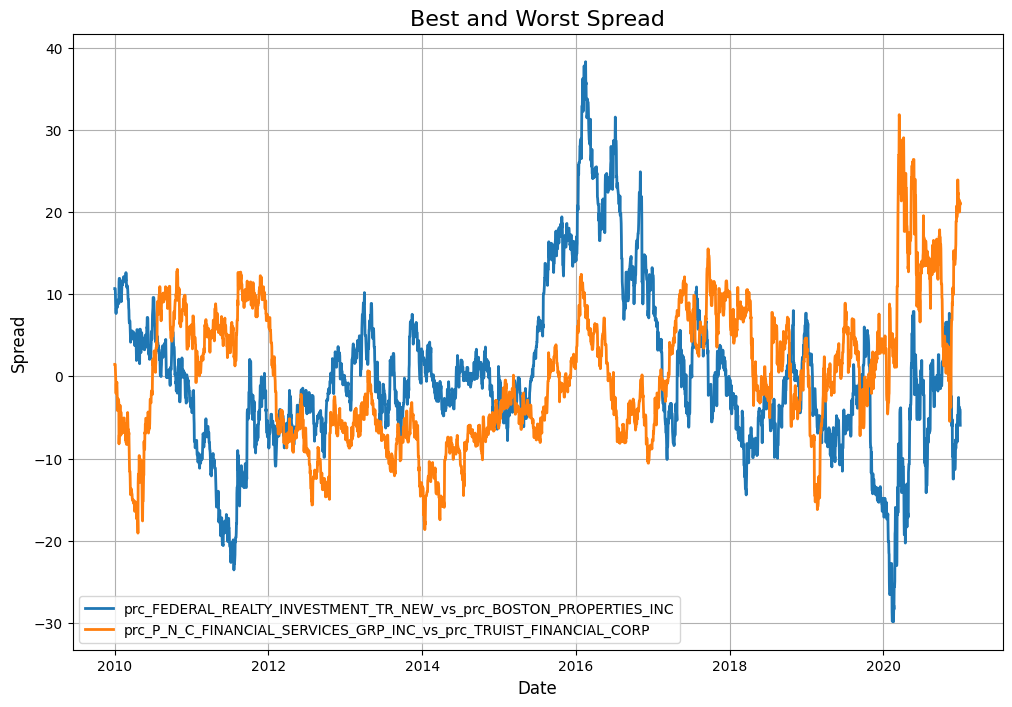

In [453]:
# Visualize the best and worst spread
plt.figure(figsize=(12, 8))
plt.plot(spreads[best_spread], label=best_spread, linewidth=2)
plt.plot(spreads[worst_spread], label=worst_spread, linewidth=2)
plt.title('Best and Worst Spread', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Spread', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Z score

In [454]:
def calculate_z_score(spread):

    mean_spread = spread.mean()
    std_spread = spread.std()

    z_score = (spread - mean_spread) / std_spread
    return z_score

In [455]:
def calculate_z_scores_for_spreads(spreads_return):

    z_scores = spreads_return.apply(calculate_z_score, axis=0)
    return z_scores

z_scores_for_spreads = calculate_z_scores_for_spreads(spreads)
z_scores_for_spreads

,prc_FIFTH_THIRD_BANCORP_vs_prc_CITIZENS_FINANCIAL_GROUP_INC,prc_CITIZENS_FINANCIAL_GROUP_INC_vs_prc_FIFTH_THIRD_BANCORP,prc_TRUIST_FINANCIAL_CORP_vs_prc_FIFTH_THIRD_BANCORP,prc_FIFTH_THIRD_BANCORP_vs_prc_TRUIST_FINANCIAL_CORP,prc_CAPITAL_ONE_FINANCIAL_CORP_vs_prc_DISCOVER_FINANCIAL_SERVICES,prc_TEXAS_INSTRUMENTS_INC_vs_prc_ANALOG_DEVICES_INC,prc_ZIONS_BANCORPORATION_N_A_vs_prc_REGIONS_FINANCIAL_CORP_NEW,prc_REGIONS_FINANCIAL_CORP_NEW_vs_prc_ZIONS_BANCORPORATION_N_A,prc_PRUDENTIAL_FINANCIAL_INC_vs_prc_PRINCIPAL_FINANCIAL_GROUP_INC,prc_ANALOG_DEVICES_INC_vs_prc_TEXAS_INSTRUMENTS_INC,...,prc_FIFTH_THIRD_BANCORP_vs_prc_P_N_C_FINANCIAL_SERVICES_GRP_INC,prc_P_N_C_FINANCIAL_SERVICES_GRP_INC_vs_prc_TRUIST_FINANCIAL_CORP,prc_FEDERAL_REALTY_INVESTMENT_TR_NEW_vs_prc_BOSTON_PROPERTIES_INC,prc_SYNCHRONY_FINANCIAL_vs_prc_CAPITAL_ONE_FINANCIAL_CORP,prc_CITIZENS_FINANCIAL_GROUP_INC_vs_prc_REGIONS_FINANCIAL_CORP_NEW,prc_KEYCORP_NEW_vs_prc_CITIZENS_FINANCIAL_GROUP_INC,prc_HUNTINGTON_BANCSHARES_INC_vs_prc_FIFTH_THIRD_BANCORP,prc_TRUIST_FINANCIAL_CORP_vs_prc_KEYCORP_NEW,prc_FIFTH_THIRD_BANCORP_vs_prc_HUNTINGTON_BANCSHARES_INC,prc_SOUTHERN_CO_vs_prc_EVERSOURCE_ENERGY
2010-01-01,NaN,NaN,1.545499,-1.866850,0.033983,0.484144,-2.176784,1.903827,0.033521,-0.655068,...,-1.823247,0.177984,1.088788,NaN,NaN,NaN,-1.042836,1.131858,0.592607,-1.232165
2010-01-02,NaN,NaN,1.545499,-1.866850,0.033983,0.484144,-2.176784,1.903827,0.033521,-0.655068,...,-1.823247,0.177984,1.088788,NaN,NaN,NaN,-1.042836,1.131858,0.592607,-1.232165
2010-01-03,NaN,NaN,1.545499,-1.866850,0.033983,0.484144,-2.176784,1.903827,0.033521,-0.655068,...,-1.823247,0.177984,1.088788,NaN,NaN,NaN,-1.042836,1.131858,0.592607,-1.232165
2010-01-04,NaN,NaN,1.490964,-1.801157,0.211235,0.454448,-2.102604,1.836430,0.166072,-0.625242,...,-1.678181,0.084130,1.014749,NaN,NaN,NaN,-1.249670,0.990271,0.807974,-1.252552
2010-01-05,NaN,NaN,1.477792,-1.779292,0.457257,0.438441,-2.114060,1.855528,0.203388,-0.609672,...,-1.573961,-0.002737,0.877861,NaN,NaN,NaN,-1.326037,0.950266,0.892753,-1.459384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.000062,-0.879561,-0.855696,1.076736,-1.283113,-0.507402,-1.481190,1.681867,-1.552144,0.906742,...,-1.419721,2.602999,-0.381194,-0.490947,-0.964894,-1.829550,-1.701074,1.053675,1.934810,0.619841
2020-12-28,0.954228,-0.834869,-0.522070,0.748348,-1.227596,-0.586440,-1.484965,1.686018,-1.575533,0.985976,...,-1.494041,2.427906,-0.514573,-0.523815,-0.981713,-1.739980,-1.526767,1.217783,1.763637,0.578762
2020-12-29,0.851141,-0.739934,-0.764261,0.977230,-1.478951,-0.406528,-1.492998,1.684808,-1.607950,0.802829,...,-1.459168,2.558871,-0.405284,-0.370736,-0.871597,-1.992902,-1.540654,1.124967,1.767257,0.587393
2020-12-30,0.486905,-0.368632,-0.410498,0.630782,-1.352116,-0.704105,-1.514725,1.714019,-1.493934,1.110047,...,-1.685985,2.536287,-0.444892,-0.439536,-0.787622,-1.913005,-1.232680,1.154810,1.468307,0.746311


In [456]:
def get_best_and_worst_z_scores(z_scores_return):

    # Calculate the maximum Z-score and minimum Z-score for each column
    max_z_score = z_scores_return.max()  # Highest Z-score for each spread
    min_z_score = z_scores_return.min()  # Lowest Z-score for each spread

    best_z_score_column = max_z_score.idxmax()
    worst_z_score_column = min_z_score.idxmin()


    return best_z_score_column, worst_z_score_column, max_z_score[best_z_score_column], min_z_score[worst_z_score_column]

best_z_col, worst_z_col, best_z_value, worst_z_value = get_best_and_worst_z_scores(z_scores_for_spreads)
print(f"The best Z-score column is: {best_z_col} with a Z-score of {best_z_value}")
print(f"The worst Z-score column is: {worst_z_col} with a Z-score of {worst_z_value}")

The best Z-score column is: prc_C_M_S_ENERGY_CORP_vs_prc_AMERICAN_ELECTRIC_POWER_CO_INC with a Z-score of 4.529122550943514
The worst Z-score column is: prc_FIFTH_THIRD_BANCORP_vs_prc_P_N_C_FINANCIAL_SERVICES_GRP_INC with a Z-score of -4.5517479176614115


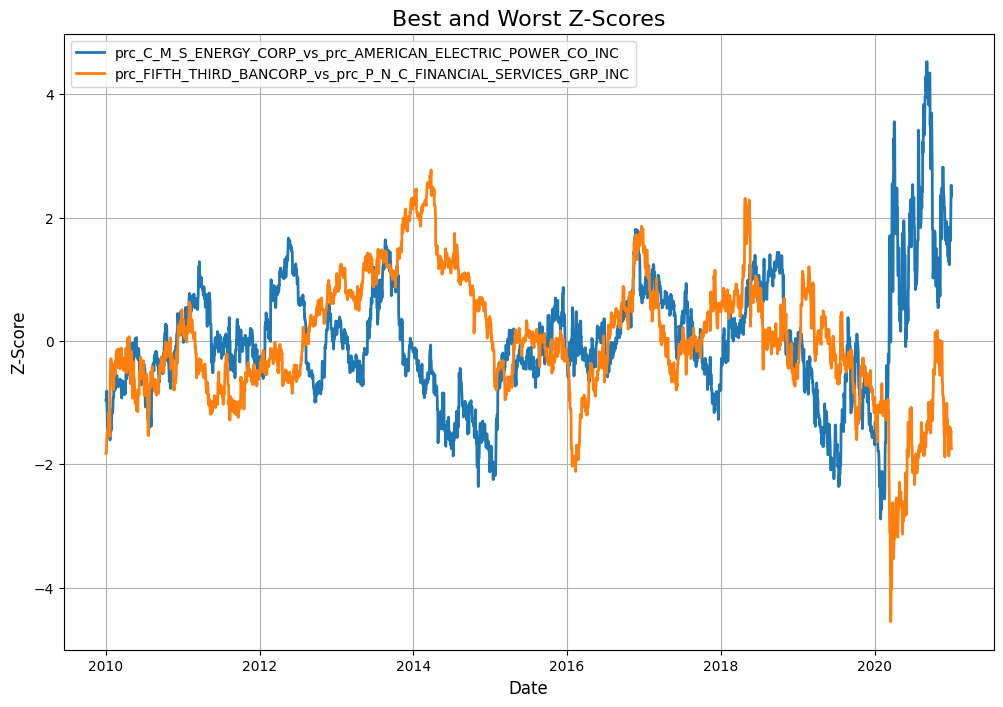

In [457]:
# Visualize the best and worst Z-scores
plt.figure(figsize=(12, 8))
plt.plot(z_scores_for_spreads[best_z_col], label=best_z_col, linewidth=2)
plt.plot(z_scores_for_spreads[worst_z_col], label=worst_z_col, linewidth=2)
plt.title('Best and Worst Z-Scores', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Z-Score', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Strategy

## For two pairs

In [458]:
def generate_trading_signals(z_scores, entry_threshold=2, exit_threshold=1):

    signals = pd.Series(index=z_scores.index, dtype=float)

    for i in range(1, len(z_scores)):
        if z_scores.iloc[i] > entry_threshold:
            signals.iloc[i] = -1  # Short
        elif z_scores.iloc[i] < -entry_threshold:
            signals.iloc[i] = 1   # Long
        elif abs(z_scores.iloc[i]) < exit_threshold:
            signals.iloc[i] = 0   # Close the position (exit)
        else:
            signals.iloc[i] = signals.iloc[i-1]  # Hold the current position

    return pd.DataFrame(signals, columns=['Signal'])


signals = generate_trading_signals(z_scores_for_spreads[z_scores_for_spreads.columns[0]])
signals

,Signal
2010-01-01,NaN
2010-01-02,NaN
2010-01-03,NaN
2010-01-04,NaN
2010-01-05,NaN
...,...
2020-12-27,0.0
2020-12-28,0.0
2020-12-29,0.0
2020-12-30,0.0


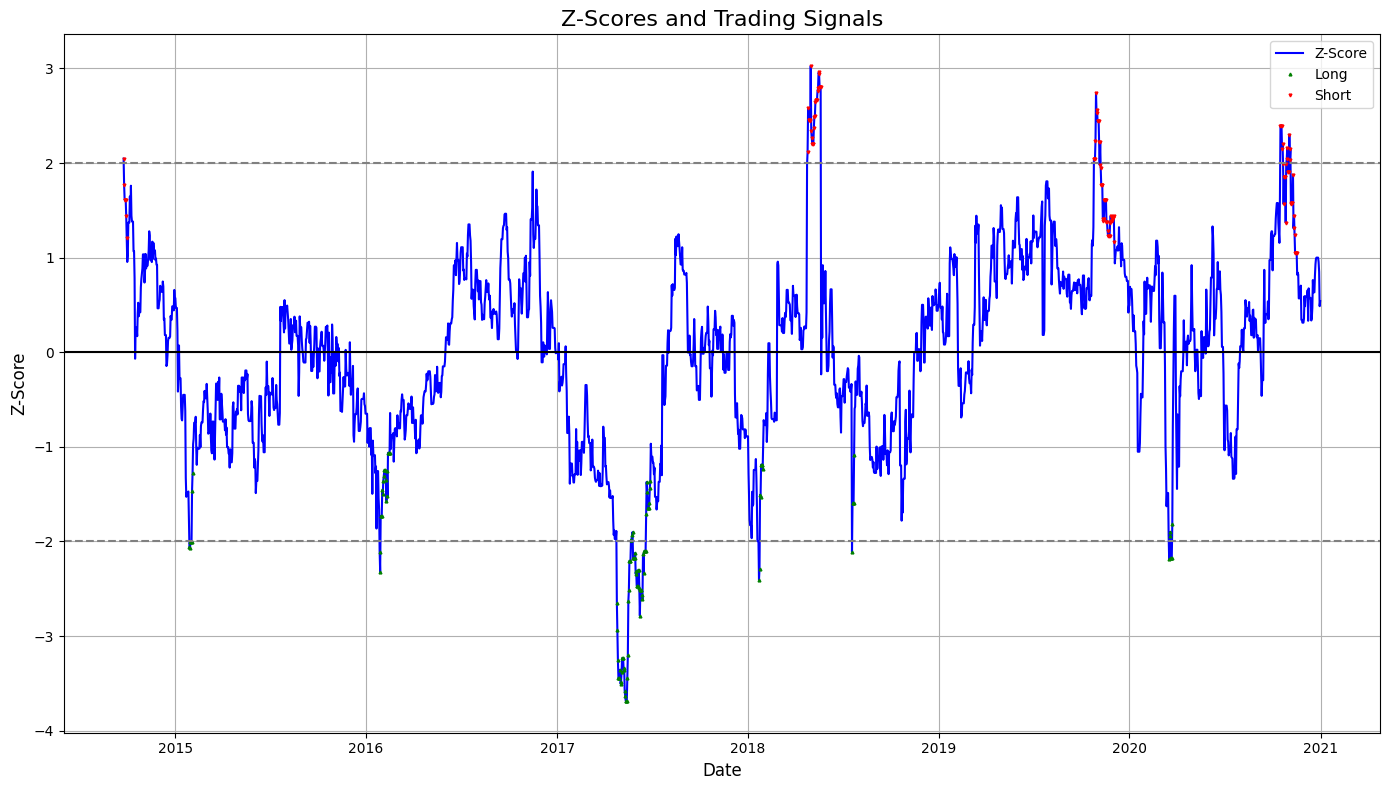

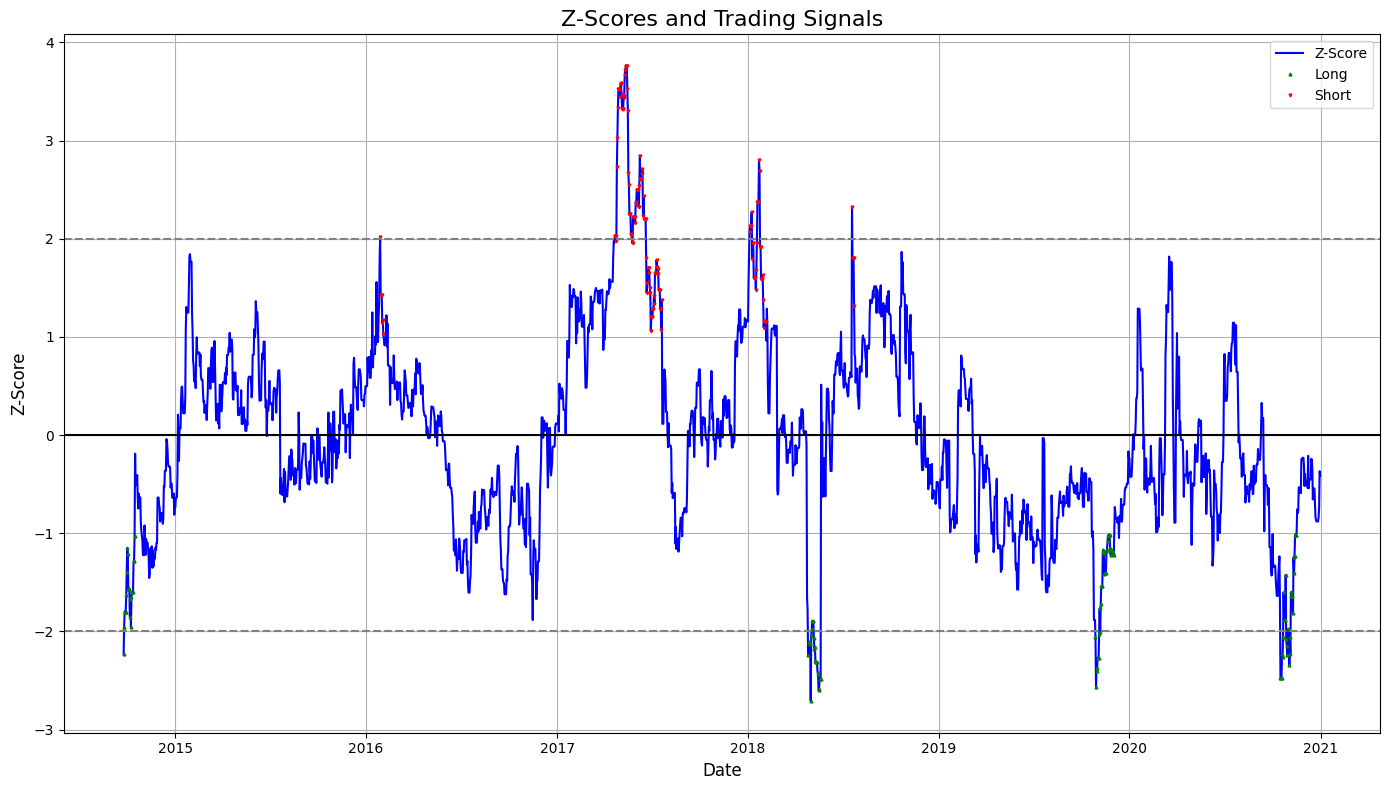

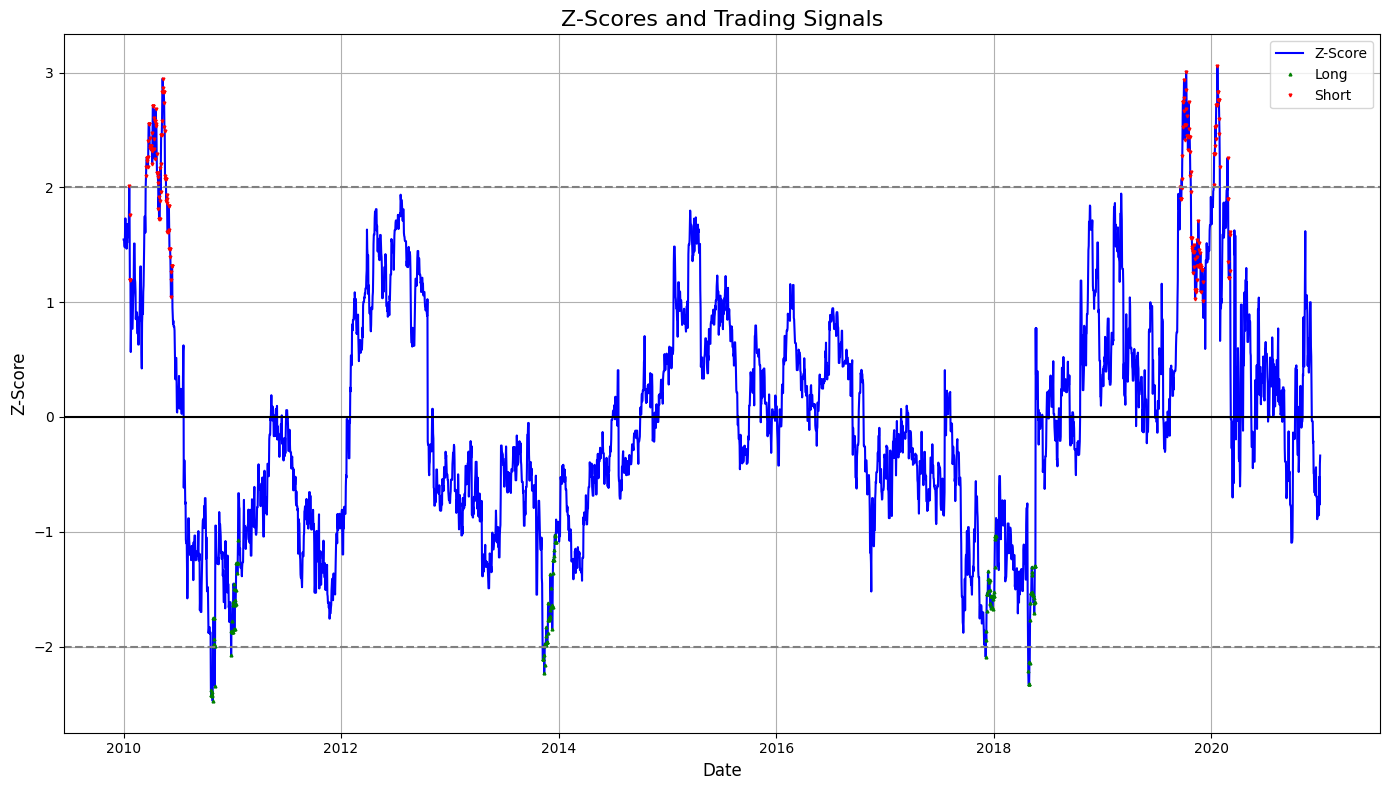

In [459]:
def plot_z_scores_with_signals(z_scores, signals, column_name):

    signal_column = signals[column_name]

    plt.figure(figsize=(14, 8))

    # Plot the Z-scores
    plt.plot(z_scores.index, z_scores, label='Z-Score', color='blue')

    # Mark long positions (1)
    plt.plot(signal_column[signal_column == 1].index, z_scores[signal_column == 1], '^', markersize=2, color='green', label='Long')

    # Mark short positions (-1)
    plt.plot(signal_column[signal_column == -1].index, z_scores[signal_column == -1], 'v', markersize=2, color='red', label='Short')

    # Add labels and legend
    plt.title('Z-Scores and Trading Signals', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Z-Score', fontsize=12)
    plt.axhline(2, color='grey', linestyle='--')  # Entry threshold
    plt.axhline(-2, color='grey', linestyle='--')  # Entry threshold
    plt.axhline(0, color='black', linestyle='-')  # Mean level
    plt.legend(loc='best')

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for k in range(3):
    spread_z_scores = z_scores_for_spreads[z_scores_for_spreads.columns[k]]
    signals = generate_trading_signals(spread_z_scores)
    plot_z_scores_with_signals(spread_z_scores, signals, 'Signal')


## For stocks

In [460]:
def simulate_orders(stock_A, stock_B, entry_threshold=2, exit_threshold=1):

    spread = stock_A - stock_B

    z_scores = calculate_z_score(spread)

    signals = generate_trading_signals(z_scores, entry_threshold, exit_threshold)

    orders = pd.DataFrame(index=spread.index)
    
    orders['Stock_A_Order'] = 0
    orders['Stock_B_Order'] = 0

    for i in range(1, len(signals)):
        if signals.iloc[i]['Signal'] == 1:  # Long position
            orders.loc[orders.index[i], 'Stock_A_Order'] = 1  # Buy stock A
            orders.loc[orders.index[i], 'Stock_B_Order'] = -1  # Short stock B
        elif signals.iloc[i]['Signal'] == -1:  # Short position
            orders.loc[orders.index[i], 'Stock_A_Order'] = -1  # Short stock A
            orders.loc[orders.index[i], 'Stock_B_Order'] = 1  # Buy stock B
        elif signals.iloc[i]['Signal'] == 0:  # Exit position
            orders.loc[orders.index[i], 'Stock_A_Order'] = 0  # Exit both stocks
            orders.loc[orders.index[i], 'Stock_B_Order'] = 0

    return orders



In [461]:
def plot_orders(stock_A, stock_B, orders):

    plt.figure(figsize=(14, 8))

    # Plot stock A and stock B prices
    plt.plot(stock_A.index, stock_A, label='Stock A Price', color='blue')
    plt.plot(stock_B.index, stock_B, label='Stock B Price', color='orange')

    # Mark Buy and Sell orders for Stock A
    plt.plot(orders[orders['Stock_A_Order'] == 1].index, stock_A[orders['Stock_A_Order'] == 1], '^', markersize=2, color='green', label='Buy Stock A')
    plt.plot(orders[orders['Stock_A_Order'] == -1].index, stock_A[orders['Stock_A_Order'] == -1], 'v', markersize=2, color='red', label='Sell/Short Stock A')

    # Mark Buy and Sell orders for Stock B
    plt.plot(orders[orders['Stock_B_Order'] == 1].index, stock_B[orders['Stock_B_Order'] == 1], '^', markersize=2, color='purple', label='Buy Stock B')
    plt.plot(orders[orders['Stock_B_Order'] == -1].index, stock_B[orders['Stock_B_Order'] == -1], 'v', markersize=2, color='brown', label='Sell/Short Stock B')

    # Add labels and legend
    plt.title('Trading Orders for Stock A and Stock B', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend(loc='best')

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [462]:
best_z_col, worst_z_col, best_z_value, worst_z_value = get_best_and_worst_z_scores(z_scores_for_spreads)
print(f"The best Z-score column is: {best_z_col} with a Z-score of {best_z_value}")
print(f"The worst Z-score column is: {worst_z_col} with a Z-score of {worst_z_value}")

The best Z-score column is: prc_C_M_S_ENERGY_CORP_vs_prc_AMERICAN_ELECTRIC_POWER_CO_INC with a Z-score of 4.529122550943514
The worst Z-score column is: prc_FIFTH_THIRD_BANCORP_vs_prc_P_N_C_FINANCIAL_SERVICES_GRP_INC with a Z-score of -4.5517479176614115


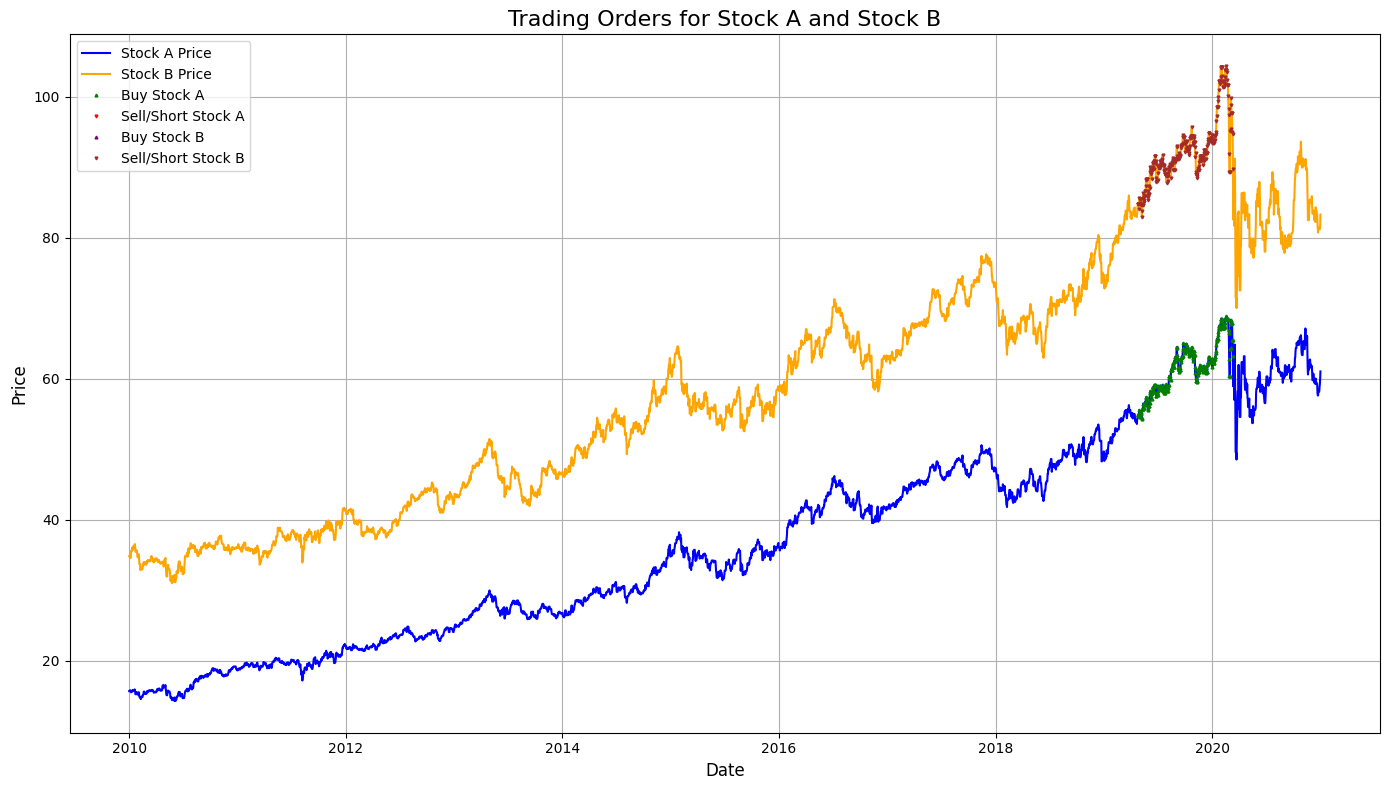

Best pair: prc_C_M_S_ENERGY_CORP and prc_AMERICAN_ELECTRIC_POWER_CO_INC


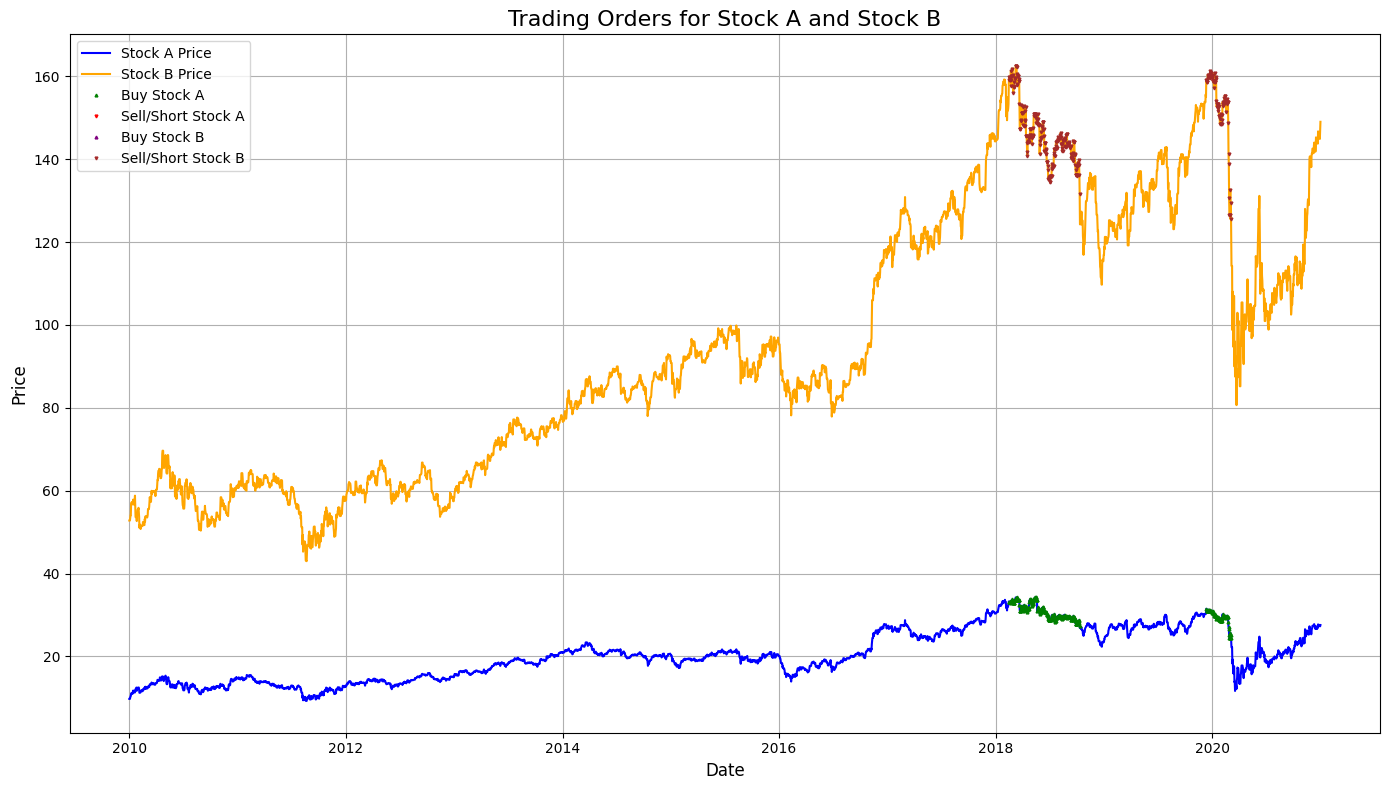

Worst pair: prc_FIFTH_THIRD_BANCORP and prc_P_N_C_FINANCIAL_SERVICES_GRP_INC


In [463]:
# Extract stock names from the best and worst Z-score column names
def extract_stock_names(z_score_column):

    stock_1, stock_2 = z_score_column.split('_vs_')
    return stock_1, stock_2

# Simulate trading orders for the best and worst Z-score pairs
best_stock_1, best_stock_2 = extract_stock_names(best_z_col)

stock_A_best = stock_prices_SP500[best_stock_1]
stock_B_best = stock_prices_SP500[best_stock_2]

orders_best = simulate_orders(stock_A_best, stock_B_best)
plot_orders(stock_A_best, stock_B_best, orders_best)

print(f"Best pair: {best_stock_1} and {best_stock_2}")

# Simulate trading orders for the best and worst Z-score pairs
worst_stock_1, worst_stock_2 = extract_stock_names(worst_z_col)

stock_A_worst = stock_prices_SP500[worst_stock_1]
stock_B_worst = stock_prices_SP500[worst_stock_2]

orders_worst = simulate_orders(stock_A_worst, stock_B_worst)
plot_orders(stock_A_worst, stock_B_worst, orders_worst)

print(f"Worst pair: {worst_stock_1} and {worst_stock_2}")


# For monday

## Maths on overleaf
## Explore and write the further ideas + Compute the for the backtest return
## Powerpoint

# PIT 2024

# Compute the return for a specific period

# Optimize the parameters for correlation, cointegration, Z score

# Select the companies (focus on couple sectors)